In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

### PARAMETERS

In [125]:
folder_inp = 'data/'            # output folder name
file_inp = 'test_data2'         # data input file name
folder_out = 'res/'             # output folder name

h_cor = 3                       # Do not consider first h_cor rows (Header) 
Freq = 100                      # Sample Frequency [Hz]
npers = 1024*2                  # Length of each segment

filepath_inp = folder_inp + file_inp + '.csv'
print(filepath_inp)

data/test_data2.csv


### OPEN ACCELEROGRAMS FILE

In [126]:
df0 = []
try:
    df0 = pd.read_csv(filepath_inp, skiprows=h_cor, header=None)
    len_df0 = len(df0)
    if len_df0 <= 1:
        raise Exception("File df0 with issues - Error: it seems empty")
except Exception as e:  
    print("Problems opening event file {} - Error: {}".format(filepath_inp, e))  

### CALCULATE FFT AND PSD

In [127]:
mY_df = []  # FFT
psd = []    # CPSD
#review npers
if npers > len_df0:
    npers = len_df0
    print('npers adjusted!')
nfft = npers//2+1
len_c_df0 = len(df0.columns)
psd3 = np.zeros((len_c_df0,len_c_df0,nfft)) # 3D array "(j,i,freqs_1)"

# Frequencies FFT
Ts = 1/Freq  
freqs_0 = np.fft.fftfreq(n=len_df0, d=Ts)     
freqs_0 = freqs_0[range(0,len_df0//2)]  

for j in range(len_c_df0):
    df0_cj = df0.iloc[:,j]
    df0_cj.reset_index(inplace=True, drop=True)
    
    # Magnitude FFT
    Y = np.fft.fft(df0_cj)/len_df0      
    Y = Y[range(0,len_df0//2)]
    Y[0] = 0
    mY = np.abs(Y)                                    
    if j == 0:
        mY_df.append(freqs_0)
    mY_df.append(mY)  

    #PSD - Cross Power Spectral Density - using Welch’s method.
    for i in range(len_c_df0):   
        df0_ci = df0.iloc[:,i]
        df0_ci.reset_index(inplace=True, drop=True)
        
        # Frequencies and Magnitude PSD
        freqs_1, psd00 = signal.csd(df0_cj, df0_ci, fs = Freq, nperseg=npers)
        psd0 = np.abs(psd00)
        #print(freqs_1)
        if j == 0 and i == 0:
            psd.append(freqs_1)   
        psd.append(psd0)  
        #print(psd)
        for k in range(len(psd0)): 
            psd3[j,i,k] = psd0[k]

print("Shape:", psd3.shape)


Save_Res1 = False
if Save_Res1 == True:
    df2 = pd.DataFrame(mY_df).T
    #print(df2)
    try:
        df2.to_csv(folder_out + 'res_FFT_' + file_inp + '.csv',index=False) 
    except Exception as e: 
        print('Problem saving res_FFT - Error:', e) 

    df3 = pd.DataFrame(psd).T
    #print(df3)
    try:
        df3.to_csv(folder_out + 'res_CPSD_' + file_inp + '.csv',index=False) 
    except Exception as e: 
        print('Problem saving res_CPSD - Error:', e) 

npers adjusted!
Shape: (27, 27, 1000)


### PLOT  PSD (selected column)

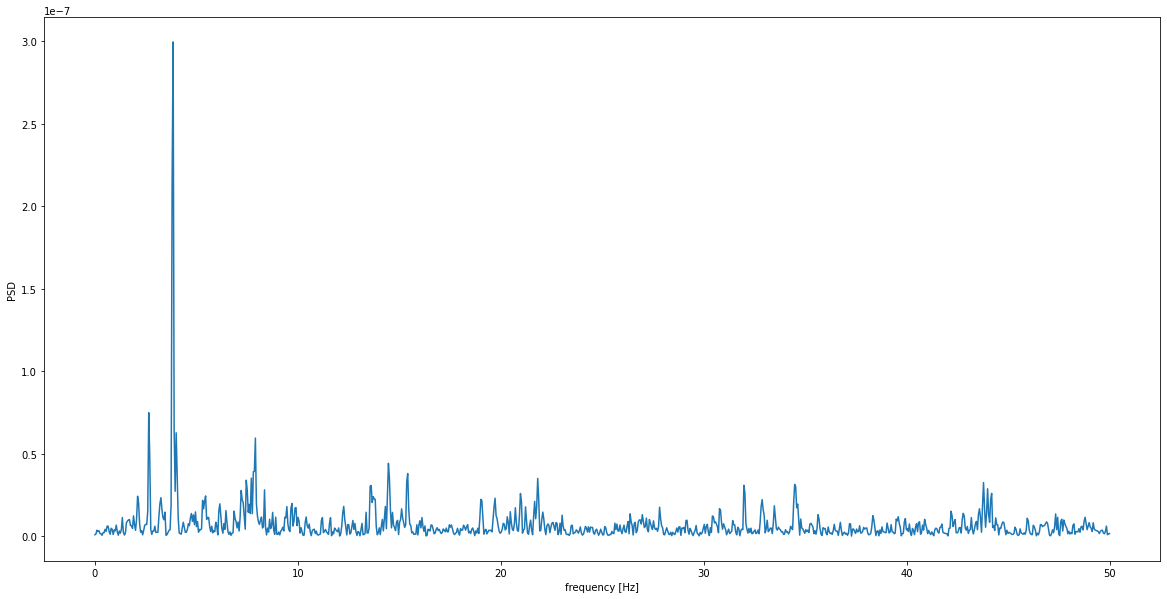

In [128]:
col0 = 3 #Select column to see - larger than 0(freqs col)

plt.figure(figsize=(20,10))
plt.plot(freqs_1, np.abs(psd[col0]))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

### SVD

In [129]:
s1 = []   # 1st svd
s2 = []   # 2nd svd

print(psd3.shape[2])
for i in range(psd3.shape[2]):
    df3_z = psd3[:,:,i]
    
    U, s, Vh = np.linalg.svd(df3_z)
    
    s1.append(s[0])
    s2.append(s[1])


df_S1 = pd.DataFrame(s1).T
print(df_S1)

Save_Res2 = True
if Save_Res2 == True:
    try:
        df_S1.to_csv(folder_out + 'res_S1_' + file_inp + '.csv',index=False) 
    except Exception as e: 
        print('Problem saving file res_s1 - Error:', e)     


1000
            0             1             2             3             4    \
0  1.056703e-07  1.215039e-07  6.457682e-08  8.053401e-08  7.504044e-08   

            5             6             7             8             9    ...  \
0  5.559114e-08  5.452051e-08  5.221517e-08  7.654973e-08  7.772692e-08  ...   

            990           991           992           993           994  \
0  1.028873e-07  1.030508e-07  7.957224e-08  7.378103e-08  7.283052e-08   

            995           996           997           998           999  
0  1.012288e-07  1.384260e-07  8.399858e-08  5.526067e-08  4.006870e-08  

[1 rows x 1000 columns]


### PLOT  SVD

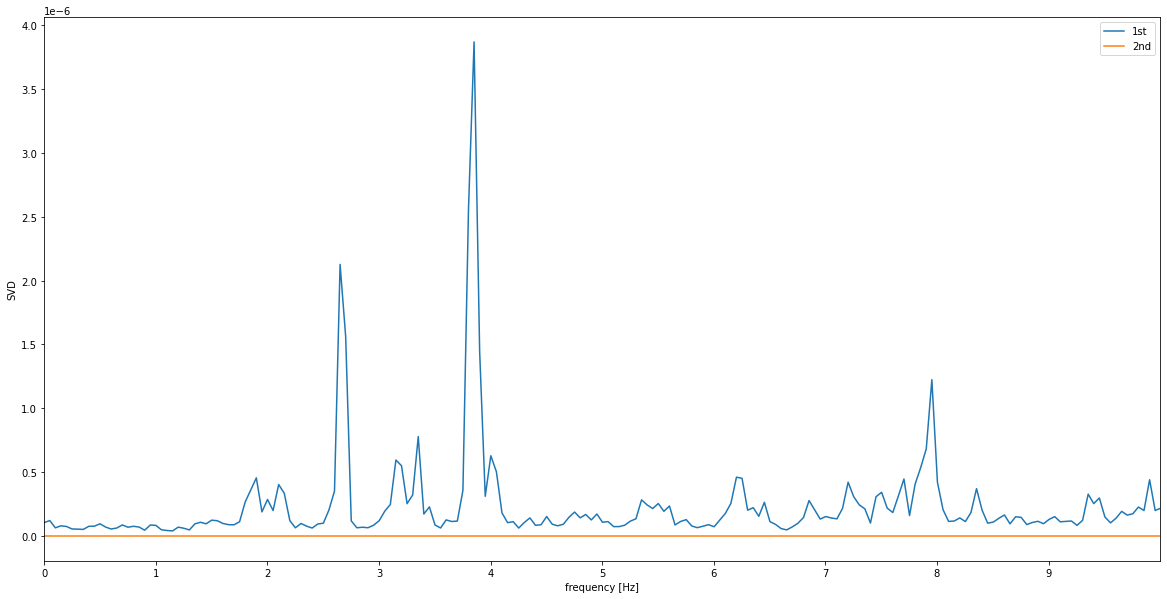

In [130]:
plt.figure(figsize=(20,10))
plt.xlim((0, 10))
plt.xticks(np.arange(0, 10, 1)) 
Plot_Log10 = False
if Plot_Log10 == True:
    plt.plot(freqs_1, (10*np.log10(s1)), label="1st")
    plt.plot(freqs_1, (10*np.log10(s2)), label="2nd")
else:
    plt.plot(freqs_1, (s1), label="1st")
    plt.plot(freqs_1, (s2), label="2nd")
plt.xlabel('frequency [Hz]')
plt.ylabel('SVD')
plt.legend(loc="upper right")
plt.show()

### 1ST MODE PEAK

In [131]:
# Find max peak
peakY = np.max(s1)  #max amplitude
print("Magnitude:", peakY)
if np.isnan(peakY) == False:
    locY = np.where(s1 == peakY)[0][0]  #peak location
    freY = freqs_1[locY]
print("Max Peak Freq:", freY)
print("position:", locY)

Magnitude: 3.867114222634708e-06
Max Peak Freq: 3.8519259629814906
position: 77


### MODE SHAPES

In [132]:
#SVD peak position
id = locY   # manual edit if pretended to see another
    
df3_z = psd3[:,:,id]

U, s, Vh = np.linalg.svd(df3_z)
print(s)


#Save to further analyse Mode Shapes
Save_Res3 = False
if Save_Res3 == True:
    try:
        df_U = pd.DataFrame(U).T
        print(df_U)
        df_U.to_csv(folder_out + 'res_U_' + str(i) + '_' + str(file_inp) + '.csv',index=False) 
    except Exception as e: 
        print('Problem saving file df_U - Error:', e) 

    try:
        df_Vh = pd.DataFrame(Vh).T
        df_Vh.to_csv(folder_out + 'res_Vh_' + str(i) + '_' + str(file_inp) + '.csv',index=False) 
    except Exception as e: 
        print('Problem saving file df_Vh - Error:', e) 

[3.86711422e-06 3.49143013e-22 3.49143013e-22 3.49143013e-22
 3.49143013e-22 3.49143013e-22 3.49143013e-22 3.49143013e-22
 3.49143013e-22 3.49143013e-22 3.49143013e-22 3.49143013e-22
 3.49143013e-22 3.49143013e-22 3.49143013e-22 3.49143013e-22
 3.49143013e-22 3.49143013e-22 3.49143013e-22 3.49143013e-22
 3.49143013e-22 3.49143013e-22 3.49143013e-22 3.49143013e-22
 3.49143013e-22 3.49143013e-22 2.73597418e-22]
